# 2_train_model.ipynb

In [32]:
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv1D
from keras.layers import GaussianNoise
# from keras.layers import MaxPooling1D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import concatenate
from keras.utils import plot_model
from keras import regularizers
# from keras import losses
# from keras import callbacks
# from keras import metrics
import keras
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

## Load Data

In [69]:
with open('data/tensors_6.pkl', 'rb') as file:
    price_series, time_categories, up_targets, dn_targets = pickle.load(file) 

with open('data/outcomes_6b.pkl', 'rb') as file:
    up_outcomes, dn_outcomes, up_outcomes_passive, dn_outcomes_passive = pickle.load(file) 

timesteps = price_series.shape[1]
channels = price_series.shape[2]
time_dim = time_categories.shape[1]

print(price_series.shape)
print(time_categories.shape)
print(up_targets.shape)
print(dn_targets.shape)
print(len(up_outcomes))
print(len(dn_outcomes))


(25232, 20, 41)
(25232, 38)
(25232, 2)
(25232, 2)
25232
25232


## Split Data

In [64]:
RANDOM_SEED = 7
TARGETS = dn_targets
OUTCOMES = dn_outcomes

# Splitting the arrays into train and test sets
train_x_price, test_x_price = train_test_split(price_series, test_size=0.2, random_state=RANDOM_SEED)
train_x_time, test_x_time = train_test_split(time_categories, test_size=0.2, random_state=RANDOM_SEED)
train_y, test_y = train_test_split(TARGETS, test_size=0.2, random_state=RANDOM_SEED)
train_outcomes, test_outcomes = train_test_split(OUTCOMES, test_size=0.2, random_state=RANDOM_SEED)

## Define Multimodal Convolutional Network

In [35]:
FILTERS = 1024
NOISE_SDEV = 0.05
DEEP_NOISE_SDEV = 0.05

keras.utils.set_random_seed(7)

# convolutional branch
input_cnn = Input(shape=(timesteps,channels)) 

noise_cnn = GaussianNoise(stddev=NOISE_SDEV, seed=7)(input_cnn)

cnn = Conv1D(filters=FILTERS, kernel_size=7, padding='same', 
             activation='relu', data_format='channels_last',
             activity_regularizer=None,
             input_shape=(timesteps, channels))(noise_cnn)

cnn = Conv1D(filters=FILTERS, kernel_size=3, padding='same', 
             activation='relu', data_format='channels_last', 
             activity_regularizer=None)(cnn)

cnn = Conv1D(filters=FILTERS, kernel_size=2, padding='same', strides=2,      # pooling layer
             activation='relu', use_bias=False, data_format='channels_last', 
             activity_regularizer=None)(cnn)

cnn = Conv1D(filters=FILTERS*2, kernel_size=3, padding='same', 
             activation='relu', data_format='channels_last', 
             activity_regularizer=None)(cnn)

cnn = Conv1D(filters=FILTERS*2, kernel_size=2, padding='same', strides=2,     # pooling layer
             activation='relu', use_bias=False, data_format='channels_last',
             activity_regularizer=None)(cnn)

cnn = Conv1D(filters=FILTERS*4, kernel_size=3, padding='same', 
             activation='relu', data_format='channels_last', 
             activity_regularizer=regularizers.L2(0.01))(cnn)

cnn = Dropout(0.4)(cnn)
cnn = Flatten()(cnn)
cnn = Model(inputs=input_cnn, outputs=cnn)

# perceptron branch
input_mlp = Input(shape=(time_dim,))
noise_mlp = GaussianNoise(stddev=DEEP_NOISE_SDEV, seed=7)(input_mlp)
mlp = Dense(8, activation='relu', 
            activity_regularizer=regularizers.L2(0.01))(noise_mlp)
mlp = Model(inputs=input_mlp, outputs=mlp)

# join branches
combined = concatenate([cnn.output, mlp.output])
head = Dense(1024, activation='relu')(combined)
head = Dense(512, activation='relu')(head)
head = Dense(2, activation='softmax')(head)
model = Model(inputs=[cnn.input, mlp.input], outputs=head)

loss = keras.losses.BinaryFocalCrossentropy(apply_class_balancing=False,    # ideally matches metric, but: https://neptune.ai/blog/implementing-the-macro-f1-score-in-keras
                                            alpha=0.25,
                                            gamma=2.0)    
 
metric = keras.metrics.F1Score(average='weighted',    
                               threshold=None, 
                               dtype=None)     
                                                          
model.compile(loss=loss,     
              optimizer='adam',     # adadelta or adamax may be better suited?                
              metrics=[metric])     # does list block optuna?

print(model.summary())

# plot_model(model, to_file='models/model_plot.png', 
#                   show_shapes=True, 
#                   show_layer_names=True, 
#                   show_layer_activations=True)

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 20, 41)]             0         []                            
                                                                                                  
 gaussian_noise_8 (Gaussian  (None, 20, 41)               0         ['input_9[0][0]']             
 Noise)                                                                                           
                                                                                                  
 conv1d_24 (Conv1D)          (None, 20, 1024)             294912    ['gaussian_noise_8[0][0]']    
                                                                                                  
 conv1d_25 (Conv1D)          (None, 20, 1024)             3146752   ['conv1d_24[0][0]']    

## Train And Evaluate Model

In [36]:
BATCH_SIZE = 256
PATIENCE = 4

callback = keras.callbacks.EarlyStopping(monitor="val_loss",  
   				 					 	 patience=PATIENCE,
    			 					  	 verbose=0,
				 						 restore_best_weights=True,)

postive_weight = train_y.sum(axis=0)[0] / train_y.sum(axis=0)[1]

model.fit(x=[train_x_price, train_x_time], 
          y=train_y,
	      validation_data=([test_x_price, test_x_time], test_y),
	      epochs=25, 
          batch_size=BATCH_SIZE, 
          callbacks=callback,
          class_weight = {0: 1,
                          1: postive_weight})

loss, accuracy = model.evaluate([test_x_price, test_x_time], 
                                test_y, 
                                batch_size=BATCH_SIZE, 
                                verbose=0)
print(loss, accuracy)

model.save('models/cnn_short6_1024_n005d.keras')

Epoch 1/25
79/79 [==============================] - 888s 11s/step - loss: 0.3029 - f1_score: 0.5922 - val_loss: 0.1802 - val_f1_score: 0.4366
Epoch 2/25
79/79 [==============================] - 973s 12s/step - loss: 0.2976 - f1_score: 0.5818 - val_loss: 0.1676 - val_f1_score: 0.6443
Epoch 3/25
79/79 [==============================] - 912s 11s/step - loss: 0.2951 - f1_score: 0.5960 - val_loss: 0.1613 - val_f1_score: 0.6806
Epoch 4/25
79/79 [==============================] - 852s 11s/step - loss: 0.2912 - f1_score: 0.6026 - val_loss: 0.1520 - val_f1_score: 0.7794
Epoch 5/25
79/79 [==============================] - 852s 11s/step - loss: 0.2887 - f1_score: 0.5848 - val_loss: 0.1756 - val_f1_score: 0.5071
Epoch 6/25
79/79 [==============================] - 869s 11s/step - loss: 0.2882 - f1_score: 0.6208 - val_loss: 0.1639 - val_f1_score: 0.6397
Epoch 7/25
79/79 [==============================] - 881s 11s/step - loss: 0.2843 - f1_score: 0.6481 - val_loss: 0.1738 - val_f1_score: 0.5980
Epoch 

## Evaluate Precision-Recall Curves

158/158 [==============================] - 54s 338ms/step


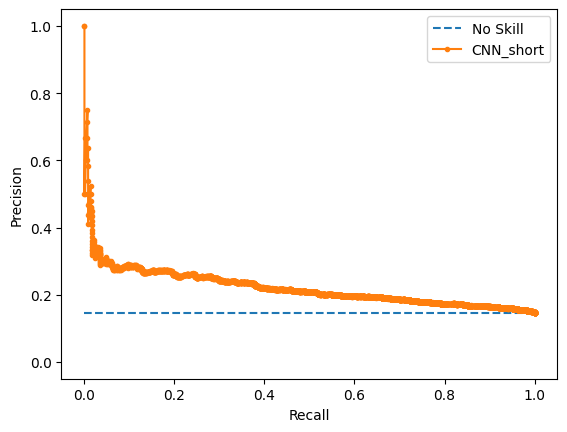

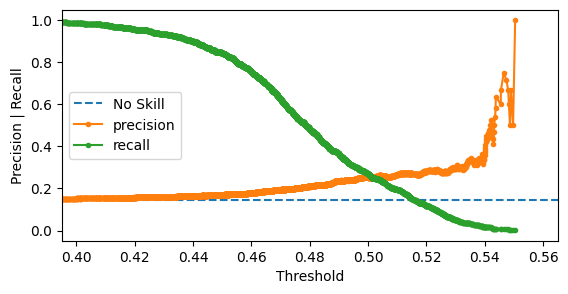

In [65]:
model = keras.models.load_model('models/cnn_short6_1024_n005d.keras')

labels = model.predict([test_x_price, test_x_time])

# keep probabilities for the positive outcome only
probs = labels[:, 1]
y_true = test_y[:, 1]

# plot the precision-recall curves
precision, recall, thresholds = precision_recall_curve(y_true, probs)
thresholds = np.append(thresholds, np.nan)
no_skill = y_true.sum() / len(test_y)

plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='CNN_short')
plt.ylim(-0.05, 1.05)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

plt.figure(figsize=(6.4,3))
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(thresholds[:], precision[:], marker='.', label='precision')
plt.plot(thresholds[:], recall[:], marker='.', label='recall')
plt.xlim(0.395, 0.565)
plt.xlabel('Threshold')
plt.ylabel('Precision | Recall')
plt.legend()
plt.show()

This shows there are no prediction thresholds where the model is able to unambigously identify the positive class.  Although given the stocastic nature of the data, this isn't surprising.

The algorithm does howver show a small predictive ability, although whether its edge outweighs the market's commision rate is unknown.  It should also be noted that 1-hr price charts are particularly noisy, and that longer timeframes can provide more reliable trading signals.

Precision vs. recall perhaps isn't the best way of determining sucess.  For example, if a long position is taken, and the market stays flat, the outcome is neutral.  A more useful analysis would compare the confusion between long predictions and short truths, _ie_ when trading capital would be lost.  Although this means remaking the model as a multi-class, rather than binary, classifier.

But - The most meaningful measure of success would be to calculate the profit/loss curves for the series of predicted trades at different prediction thresholds...

## Calculate profit/loss

[1.0009118977754665, 0.9962848175664774, 1.000655732188699, 0.9948289254163182, 1.000779150081753, 0.9962523086489258, 1.0007750898488559, 1.000710225087132, 0.9948874629436907, 1.0042918398762415]
[1.0009118977754665, 1.000655732188699, 0.9948289254163182, 1.000779150081753, 1.0007750898488559, 1.000710225087132, 0.9948874629436907, 1.0042918398762415]
[1.0009118977754665, 0.9948289254163182, 1.000779150081753, 1.000710225087132, 0.9948874629436907, 1.0042918398762415]
[1.0009118977754665, 1.000710225087132]


C:\Users\catie\AppData\Local\Temp\ipykernel_17296\1166755054.py:13: RuntimeWarning: divide by zero encountered in scalar divide
  return round(wins / losses, 3)


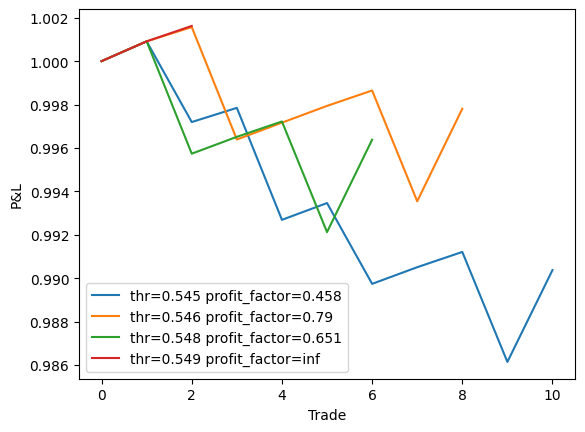

In [82]:
import pandas as pd

def profit_factor(pl_list):
    wins = 0.0
    losses = 0.0
    print(pl_list)
    for result in pl_list:
        if result > 1:
            wins += (result - 1) 
        else:
            losses += (1 - result) 

    return round(wins / losses, 3)


assert len(labels) == len(test_outcomes)

THRESHOLDS = [0.545, 0.546, 0.548, 0.549]

df2 = pd.DataFrame()

for threshold in THRESHOLDS:
    results = []
    for i, label in enumerate(labels):
        if label[1] >= threshold:
            results.append(OUTCOMES[i])

    profit_loss = np.ones(len(results)+1)
    for i, result in enumerate(results):
        profit_loss[i+1] = profit_loss[i] * results[i]


    df3 = pd.DataFrame(profit_loss, columns=[f'thr={threshold} profit_factor={profit_factor(results)}'])
    df2 = pd.concat([df2, df3], axis=1)

plt.plot(df2, label=list(df2.columns.values))
plt.xlabel('Trade')
plt.ylabel('P&L')
plt.legend()
plt.show()


### Notes

In [24]:
## add cross validation
## pad - most recent edge is important! #
## replace maxpooling with dilated kernel to preserve data - geoff hinton #
## replace maxpooling with stride = 2 - 'learnable pooling, all-convolution network' #
## batch norm on conv layers? #
## groups = channels maintains depthwise separation.  Add same multiple of filters?
## l2 less sensitive to small changes (noise), l1 blocks some inputs #
## layers.DepthwiseConv1D() reduces number of parameters
## model.train(sample_weight=) heavier recent samples

print(len(labels))
print(labels)
print(test_y)

5045
[[0.5951229  0.40487716]
 [0.53520316 0.46479693]
 [0.66677636 0.33322367]
 ...
 [0.49995318 0.50004685]
 [0.46632093 0.53367907]
 [0.4918398  0.5081603 ]]
[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [1. 0.]
 [1. 0.]]
